In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from FairnessEvaluator import FairnessEvaluator

import matplotlib.pyplot as plt 

In [9]:
df_raw = pd.read_csv('data/Odata2021File.csv',delimiter=';')

/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (117,118,119,121,123,124,125,126,137,138,139,141,143,144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df = df_raw.copy()

DEBUG: Working on Ukr


KeyboardInterrupt: 

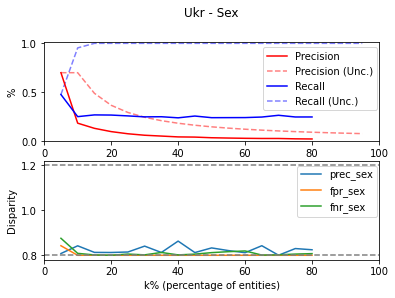

In [19]:
test_list = ['Ukr', 'Hist', 'Math', 'Phys', 'Chem', 'Geo', 'Eng', 'Deu'] #Fra, Spa

results_columns = ['dataset','sample_size','overall_prev','sensitive_attr','group_dist','group_prev','max_group_prev_diff']
results_df = pd.DataFrame(
            columns=(results_columns)
)

fo_results = {}

def maxDiff(a):
    a.sort()
    vmin = a[0]
    dmax = 0
    for i in range(len(a)):
        if (a[i] < vmin):
            vmin = a[i]
        elif (a[i] - vmin > dmax):
            dmax = a[i] - vmin
    return dmax

# New codes:
# 0 - Passed
# 1 - Failed

test_results_recoder = {'Зараховано': 0,
                        'Не подолав поріг': 1}

# New codes:
# 0 - Male
# 1 - Female

sex_recoder = {'чоловіча': 0,
               'жіноча': 1}

sex_names = {0: 'Male',
             1: 'Female'}

# New codes:
# 0 - Rural
# 1 - Urban

territory_recoder = {'місто':1,
                     'селище, село':0,
                     'селище міського типу':0}

territory_names = {0: 'Rural',
                   1: 'Urban'}

sample_dfs = {}

for test in test_list:
    print(f"DEBUG: Working on {test}")
    dataset_name = test

    # Dict for new record
    r = {}
    r['dataset'] = test

    # Clear df_temp
    df_temp = None

    # Load test data into df_temp
    df_temp = df[df[test+'TestStatus'].notnull()]

    # Drop candidates who didn't take the exam
    df_temp = df_temp[df_temp[test+'TestStatus'] != 'Не з’явився']
    df_temp = df_temp[df_temp[test+'TestStatus'] != 'Не обрано 100-200']
    df_temp = df_temp[df_temp[test+'TestStatus'] != 'Анульовано']

    # Recode sex and race
    df_temp['sex'] = df_temp['SexTypeName'].map(sex_recoder)
    df_temp['territory'] = df_temp['TerTypeName'].map(territory_recoder)
    df_temp['label'] = df_temp[test+'TestStatus'].map(test_results_recoder)
    df_temp = df_temp.filter(items=['sex','territory','label'])

    increase_test_size = True
    test_size = 0.005
    while increase_test_size:
        if df_temp.shape[0]*test_size < 1000:
            test_size+=0.005
        else:
            increase_test_size = False
    
    _, sample_df = train_test_split(df_temp, test_size=test_size, stratify=df_temp[['territory','sex','label']],random_state=42)
    sample_df = sample_df.reset_index()
    #sample_df.to_csv('for_lucius/eie_deu_sample.csv',index=None)

    sample_dfs[dataset_name] = sample_df

    r['sample_size'] = sample_df.shape[0]
    r['overall_prev'] = round(sample_df['label'].value_counts(normalize=True)[1]*100, 2)

    sample_df['sex_names'] = sample_df['sex'].map(sex_names)
    sample_df['territory_names'] = sample_df['territory'].map(territory_names)    

    # Get sex dist
    sex_dist_dict = {}
    sex_dist = sample_df['sex_names'].value_counts(normalize=True)
    for x in list(sample_df['sex_names'].unique()):
        sex_dist_dict[x] = round(sex_dist[x]*100,2)

    # Get sex group prev
    sex_prev_dict = {}
    sex_prev = pd.crosstab(sample_df['sex_names'], sample_df['label'], normalize='index')
    for x in list(sample_df['sex_names'].unique()):
        sex_prev_dict[x] = round(sex_prev[1][x]*100,2)

    sex_max_prev_diff = round(maxDiff(list(sex_prev_dict.values())),2)

    r['sensitive_attr'] = 'sex'
    r['group_dist'] = sex_dist_dict
    r['group_prev'] = sex_prev_dict
    r['max_group_prev_diff'] = sex_max_prev_diff

    results_df = results_df.append(r, ignore_index=True)

    #print("Sex: ")
    fo = FairnessEvaluator(sample_df,
                        'label',
                        ['sex'],
                        metrics=['tpr','fpr','fnr'],
                        metrics_to_plot=['prec','fpr','fnr'],
                        fairness_bounds=[0.8,1.2],
                        fully_constrained=False,
                        #metric_fairness_bounds={'tpr': [0.95,1.05]},
                        #intersectionality=None,
                        precision_ub = 0.7#,
                        #disparity_ratio=True,
                        #epsilon=0.05
                        )

    fo.evaluate()
    fo.plot()
    plt.title(f'{dataset_name} - Sex', y=2.4)

    key_temp = f'{dataset_name}_sex'
    fo_results[key_temp] = fo.results_df

    # Get territory dist
    territory_dist_dict = {}
    territory_dist = sample_df['territory_names'].value_counts(normalize=True)
    for x in list(sample_df['territory_names'].unique()):
        territory_dist_dict[x] = round(territory_dist[x]*100,2)

    # Get race group prev
    territory_prev_dict = {}
    territory_prev = pd.crosstab(sample_df['territory_names'], sample_df['label'], normalize='index')
    for x in list(sample_df['territory_names'].unique()):
        territory_prev_dict[x] = round(territory_prev[1][x]*100,2)

    territory_max_prev_diff = round(maxDiff(list(territory_prev_dict.values())),2)

    r['sensitive_attr'] = 'territory'
    r['group_dist'] = territory_dist_dict
    r['group_prev'] = territory_prev_dict
    r['max_group_prev_diff'] = territory_max_prev_diff

    results_df = results_df.append(r, ignore_index=True)

    fo = FairnessEvaluator(sample_df,
                        'label',
                        ['territory'],
                        metrics=['tpr','fpr','fnr'],
                        metrics_to_plot=['prec','fpr','fnr'],
                        fairness_bounds=[0.8,1.2],
                        #metric_fairness_bounds={'tpr': [0.999,1.001]},
                        fully_constrained=False,
                        #intersectionality=None,
                        precision_ub = 0.7,
                        #disparity_ratio=True,
                        #epsilon=0.03
                        )
    fo.evaluate()
    fo.plot()
    plt.title(f'{dataset_name} - Territory', y=2.4)

    key_temp = f'{dataset_name}_territory'
    fo_results[key_temp] = fo.results_df

In [16]:
#fo_results['Deu_territory'].filter(items=['k_perc','group_confusion_matrix']).to_csv('for_lucius/territory_k_lists.csv',index=None)

In [ ]:
#results_df['prev_ratio'] = results_df.apply(lambda row: (row['max_group_prev_diff'] / row['overall_prev']), axis=1)
results_df

In [ ]:
results_df.to_csv('results/zno-results.csv',index=False)